# Downloading data from s3

In [1]:
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import polars as pl

/tmp/ipykernel_3480495/2401917963.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Loading data

In [2]:
# models = ['70m-deduped', '160m-deduped', '410m-deduped', '1b-deduped', '1.4b-deduped', '2.8b-deduped', '6.9b-deduped', '12b-deduped']
# checkpoints = [23000, 43000, 63000, 83000, 103000, 123000, 143000]
# checkpoint_names = ['23M', '44M', '65M', '85M', '105M', '126M', '146M']
models = ['70m-v0']
checkpoints = [23000, 43000, 63000, 83000, 103000, 123000, 143000]
checkpoint_names = ['44M', '65M', '85M', '105M', '126M', '146M']
filepath = 'results/memorization-evals/evals-running/'

In [3]:
import os
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()

In [5]:
import glob
memorization_results = {}
df = None
for model in reversed(models):
    for checkpoint in tqdm(checkpoints, desc=model):
        filename = os.path.join(filepath, f'memorization_{model}_{checkpoint}.hdf')
        m_name = model.split('-')
        m_name = f'{m_name[0][:-1] + m_name[0][-1].capitalize()}-{m_name[1]}'
        model_name = f'{m_name}-{checkpoint}'

        csv = pl.scan_csv(os.path.join(filepath, f'memorization_{model}_{checkpoint}/*.csv'), has_header=False, new_columns=['index', model_name + '_accuracy'])
        if df is None:
            df = csv
        else:
            df = df.join(csv, on='index', how='inner')
        # all_files = glob.glob(os.path.join(filepath, f'memorization_{model}_{checkpoint}/*.csv'))
        # csv = pd.concat((pd.read_csv(f, names=['index', 'accuracy']) for f in all_files), ignore_index=True)
        # csv.to_hdf(filename, key='memorization', index=False)
        # memorization_results[model_name] = csv

70m-v0:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
df.select(
    ((pl.col("70M-v0-23000_accuracy") == 1) & (pl.col("70M-v0-143000_accuracy") < 1)).alias('1-0'),
    ((pl.col("70M-v0-23000_accuracy") < 1) & (pl.col("70M-v0-143000_accuracy") < 1)).alias('0-0'),
    ((pl.col("70M-v0-23000_accuracy") == 1) & (pl.col("70M-v0-143000_accuracy") == 1)).alias('1-1'),
    ((pl.col("70M-v0-23000_accuracy") < 1) & (pl.col("70M-v0-143000_accuracy") == 1)).alias('0-1'),
).sum().collect()


: 

In [42]:
for m in models:
    print(m)

70m-v0


# Simple Multiprocess Manager

# Model Accuracy Linear Regression plot

In [15]:
from itertools import cycle
import multiprocessing as mp
import scipy.stats as stats
from sklearn.metrics import r2_score

def plot_linear_regression_of_model(model, models, lock, percentile=0):
    '''Wrapper Script to plot regression lines between memorization accuracy measured and Sequence Index
    
    `model`: Name of model
    `models`: Dictionary of list of model names along with their corresponding checkpoints.
    `percentile`: Sample only Indicies with accuracy more than or equal to k percentile accuracy
    
    Utilizes global variable `memorization_results` to get the required evals.
    
    Plots the regression lines with confidence intervals and stores regression metrics in a csv.
    
    Metrics Stored:
        "model": Name of the model plotted
        "checkpoint": Checkpoint of the model plotted
        "most memorized percentile": `percentile` parameter of the current function
        If L(x, p) denotes the line of best fit for model p at Sequence Index x, then we store
        "slope": Defined as [L(x_max, p) - L(0, p)] / x_max
        "variation": Total variation, defined as L(x_max, p) - L(0, p)
        "% change": Percentage change induced by variation, defined as [L(x_max, p) - L(0, p)]/L(0, p)
    '''
    # Initialization and beautification
    cycol = cycle(['violet', 'indigo', 'blue', 'green', 'yellow', 'orange', 'red'])
    update_params()
    fig = matplotlib.figure.Figure()
    ax = fig.subplots()
    res = {}
    print(" ", end="", flush=True) # Bug of jupyter notebook. For more info, refer: https://github.com/tqdm/tqdm/issues/485
    bar = tqdm(
        desc=f'{model}-top {percentile} Linear Regression',
        total=len(models[model])
    )
    
    # Iterating through checkpoints
    for (model_name, evals) in memorization_results.items():
        m, checkpoint = model_name.split('-')
        if(m != model): continue
        checkpoint = int(checkpoint)
        res[checkpoint] = plot_linear_regression_of_checkpoint(model_name, evals, ax, next(cycol), 
            percentile)
        bar.update(1)
    
    # Titling and labeling plot
    fig.suptitle("Memorization Accuracy", fontsize=20)
    fig.supxlabel("Sequence Index", fontsize=20)
    fig.supylabel("Accuracy", fontsize=20)
    ax.legend(loc='lower right')
    
    # Saving plots and metrics
    fig.savefig(f'./plots/{model}-{percentile}_linear_regression.png', facecolor='white')
    lock.acquire()
    with open(f'./results/linear_regression.csv', 'a') as f:
        for checkpoint, scores in res.items():
            f.write(f'{model},{checkpoint},{percentile}')
            for score in scores:
                f.write(f',{score}')
            f.write('\n')
    bar.close()
    lock.release()
    
    
    

def plot_linear_regression_of_checkpoint(model_name, evals, axis, color, precentile = 0):
    '''Generates a linear regression plot and returns a tuple of results
    
    `model_name`: String with model and it's checkpoint
    `evals`: Evaluation results of corresponding model on corresponding checkpoint
    `axis`, `color`: Plotting params
    `percentile`: Sample only Indicies with accuracy more than or equal to k percentile accuracy
    
    Returns:
        tuple(
            slope: slope of regression line
            variation: Total variation, defined above
            % change: percentage change induced by variation, defined above
        )
    '''
    # Top percentile evals
    top_percentile_accuracy = np.percentile(evals['accuracy'],precentile)
    top_percentile_evals = evals[evals['accuracy'] >= top_percentile_accuracy]
    
    # Actually performing regression
    indicies, accuracy = top_percentile_evals['index'], top_percentile_evals['accuracy']
    a,b = np.polyfit(indicies, accuracy,1)
    acc_best_fit = a*indicies+b
    results = (
        a, # Slope
        acc_best_fit.iloc[-1] - acc_best_fit.iloc[0], # Variation
        (acc_best_fit.iloc[-1] - acc_best_fit.iloc[0])*100/acc_best_fit.iloc[0] # % change
    )
    
    # Confidence Interval plots
    y_model = np.polyval([a, b], indicies)
    x_mean = indicies.mean()
    y_mean = accuracy.mean()
    dof = len(indicies) - 2
    t = stats.t.ppf(0.99999, dof) 
    residual = accuracy - y_model
    std_error = (np.sum(residual**2) / dof)**.5
    x_line = np.linspace(np.min(indicies), np.max(indicies), int(1e6))
    y_line = np.polyval([a, b], x_line)
    ci = t * std_error * (1/len(indicies) + (x_line - x_mean)**2 / np.sum((indicies - x_mean)**2))**.5
    
    # Actually plotting data
    axis.plot(x_line, y_line,
        color=color, label=model_name)
    axis.fill_between(x_line, (y_line-ci), (y_line+ci), color=color, alpha=0.2)
    return results

# Bucketed Memorization Plots

In [37]:
from itertools import cycle
cycol = cycle(['violet', 'indigo', 'blue', 'green', 'yellow', 'orange', 'red'])

def plot_bucketed_scores_of_model(model, models, lock, percentile=0, metric='accuracy'):
    '''Wrapper Script to plot bucketed mean plots between memorization accuracy measured and Sequence Index
    
    `model`: Name of model
    `models`: Dictionary of list of model names along with their corresponding checkpoints.
    `percentile`: Sample only Indicies with accuracy more than or equal to k percentile accuracy
    `metric`: Could be one of accuracy or nll_loss. Using Accuracy only for now.
    
    Utilizes global variable `memorization_results` to get the required evals.
    
    Plots the bucketed memorization plots.
    '''
    # Initialization and beautification
    cycol = cycle(['violet', 'indigo', 'blue', 'green', 'yellow', 'orange', 'red'])
    fig = matplotlib.figure.Figure()
    ax = fig.subplots()
    print(" ", end="", flush=True)
    bar = tqdm(
        desc=f'{model}-top {percentile} Bucketed Memorization',
        total=len(models[model])
    )
    
    # Iterating through checkpoints
    for (model_name, evals) in memorization_results.items():
        m, n, checkpoint = model_name.split('-')
        m = m + '-' + n
        # print(m, model)
        # if(m != model): continue
        checkpoint = int(checkpoint)
        plot_bucketed_scores_of_checkpoint(
            model_name, evals, 
           ax, next(cycol), 
           percentile, 
           metric=metric
        )
        bar.update(1)
    
    # Titling and labeling plot
    fig.suptitle("Bucketed Memorization Accuracy", fontsize=20)
    fig.supxlabel("Sequence Index", fontsize=20)
    fig.supylabel("Accuracy", fontsize=20)
    ax.legend(loc='lower right')
    
    # Saving plot
    fig.savefig(f'./plots/{model}-{percentile}_bucketed_memorization.png', facecolor='white')
    bar.close()

def plot_bucketed_scores_of_checkpoint(
    model_name, evals, axis, color, 
    precentile = 0, 
    bucket_size=235520,
    metric='accuracy'
):
    '''Plots bucketed memorization scores
    
    `model_name`: String with model and it's checkpoint
    `evals`: Evaluation results of corresponding model on corresponding checkpoint
    `axis`, `color`: Plotting params
    `percentile`: Sample only Indicies with accuracy more than or equal to k percentile accuracy
    `bucket_size`: Number of samples to group into one bucket, Score of a bucket is individual scores' mean
    `metric`: Is only accuracy for now
    '''
    # Top percentile evals
    top_percentile_metric = np.percentile(evals[metric],precentile)
    top_percentile_evals = evals[evals[metric] >= top_percentile_metric]
    
    # Bucketing data and calculating errors
    indicies = []
    metric_means = []
    metric_errs = []
    for i in range(0, (len(evals)),bucket_size):
        result = top_percentile_evals[
            (i <= top_percentile_evals['index']) & 
            (top_percentile_evals['index'] < (i+bucket_size))
        ]
        if(len(result) == 0):
            continue
        indicies.append(result['index'].iloc[-1])
        metric_means.append(result[metric].mean())
        metric_errs.append(result[metric].std()/np.sqrt(len(result)))
    
    # Plotting the results
    axis.plot(indicies, metric_means, label=model_name, color=color)

# Parallelizing plot generations

In [ ]:
update_params()
manager = MPManager()
# lock = mp.Lock()
# with open('./results/linear_regression.csv', 'w') as f:
#     f.write('model,checkpoint,most memorized percentile,slope,variation,% change\n')
# for model in memorization_results.keys():
#     manager.add(mp.Process(target=plot_bucketed_scores_of_model, args=(model, memorization_results, lock, 0)))
#     manager.add(mp.Process(target=plot_bucketed_scores_of_model, args=(model, memorization_results, lock, 90)))
#     manager.add(mp.Process(target=plot_bucketed_scores_of_model, args=(model, memorization_results, lock, 99)))
#     manager.add(mp.Process(target=plot_linear_regression_of_model, args=(model, memorization_results, lock, 0)))
#     manager.add(mp.Process(target=plot_linear_regression_of_model, args=(model, memorization_results, lock, 99)))
#     manager.add(mp.Process(target=plot_linear_regression_of_model, args=(model, memorization_results, lock, 90)))
# manager.join()
plot_bucketed_scores_of_model('70M-v0-43000', memorization_results, lock, 0)

70M-v0-43000-top 0 Bucketed Memorization:   0%|          | 0/44032000 [00:00<?, ?it/s]

# Normalized Signal Cross Correlation

In [11]:
import matplotlib
import scipy.signal
from itertools import cycle
from multiprocessing import Process
cycol = cycle(['violet', 'indigo', 'blue', 'green', 'yellow', 'orange', 'red'])


def plot_normalized_cross_correlation_of_model(model, checkpoint, models):
    '''Wrapper Script to plot Normalized Signal Cross Correlation between two checkpoints of a model
    
    `model`: Model name
    `checkpoint`: Checkpoint of the corresponding model to be correlated from
    `evals`: Evaluation results of corresponding model on corresponding checkpoint
    `axis`, `color`: Plotting params
    '''
    # Initialization and beautification
    cycol = cycle(['violet', 'indigo', 'blue', 'green', 'yellow', 'orange', 'red'])
    fig = matplotlib.figure.Figure()
    ax = fig.subplots()
    print(" ", end="", flush=True)
    bar = tqdm(
        desc=f'{model}-{checkpoint} Cross Correlation',
        total=len(models[model][models[model].index(int(checkpoint)):]) - 1
    )
    one_evals = memorization_results[f'{model}-{checkpoint}']
    corr_peaks = {}
    
    # Iterating through checkpoints
    for (model_two, evals) in memorization_results.items():
        m, c = model_two.split('-')
        if(m != model): continue
        if(int(c) <= int(checkpoint)): continue
        name, peak = plot_normalized_cross_correlation(
            f'{model}-{checkpoint}', one_evals, 
            model_two, evals,
            ax, next(cycol)
        )
        corr_peaks[name] = peak
        bar.update(1)
    
    # Titling and labeling plot
    handles, labels = fig.gca().get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: -corr_peaks[t[0]]))
    fig.suptitle("Memorization Accuracy Cross Correlation", fontsize=20)
    fig.supxlabel("Correlation Lags", fontsize=20)
    fig.supylabel("Discrete Linear Normalized Correlation", fontsize=20)
    ax.set_xlim(-1e5, 1e5)
    ax.legend(handles, labels, loc='lower right')
    
    # Saving plot
    fig.savefig(f'./plots/{model}-{checkpoint}_normalized_correlation.png', facecolor='white')
    bar.close()


def normalized_corr(x, y):
    '''Performs Normalized Signal Correlation, Defined as:
    $$ normalized (f * g)(\tau) = \frac{1}{N}\frac{((f-\mu_f) * (g - \mu_g))(\tau)}{\sigma_f\sigma_g} $$
    where 
        a*b(\tau) is full discrete linear cross-correlation of a and b
        
    returns Correlation and It's correlation lags
    '''
    x -= x.mean()
    y -= y.mean()
    corr = scipy.signal.correlate(x, y)
    corr /= (np.sqrt(np.sum(x**2) * np.sum(y**2)))
    corr_lags = scipy.signal.correlation_lags(len(x), len(y))
    return corr, corr_lags

def plot_normalized_cross_correlation(name_one, evals_one, name_two, evals_two, axis, color):
    '''Plots Normalized Cross Correlation
    
    `name_one`, `name_two`: Model names with checkpoints
    `eval_one`, `eval_two`: Evaluation Results
    `color`: Beautifying parameter
    '''
    # Extract Data
    model_one, checkpoint_one = name_one.split('-')
    corr_peaks = {}
    model_two, checkpoint_two = name_two.split('-')
    x = evals_one['accuracy']
    y = evals_two['accuracy'][:len(x)]
    
    # Perform correlation
    corr, corr_lags = normalized_corr(x, y)
    
    # Plotting
    plot_color = next(cycol)
    plot_label = f'{model_one}: {checkpoint_one} and {checkpoint_two}'
    axis.plot(corr_lags, corr, label = plot_label,color=plot_color)
    
    # Indicate peaks
    corr_peaks[plot_label] = np.max(corr)
    axis.plot(corr_lags[np.argmax(corr)], np.max(corr), '_', 
             markersize=32.0, markeredgewidth=2.0, color=plot_color)
    return plot_label, np.max(corr)

In [12]:
manager = MPManager()
tot_processes = 0
for model_one, checkpoints in models.items():
    for checkpoint_one in checkpoints:
        if(checkpoint_one in [143000, 71500]): continue # No models to correlate with 143000 and 71500
            # Since these are final checkpoints
        manager.add(Process(target=plot_normalized_cross_correlation_of_model, args=(model_one, 
            str(checkpoint_one), models)))
        tot_processes+=1
        if(tot_processes >= mp.cpu_count()):
            tot_processes = 0
            manager.join()
    
manager.join()

13B-23000 Cross Correlation:   0%|          | 0/6 [00:00<?, ?it/s]

13B-43000 Cross Correlation:   0%|          | 0/5 [00:00<?, ?it/s]

13B-63000 Cross Correlation:   0%|          | 0/4 [00:00<?, ?it/s]

13B-83000 Cross Correlation:   0%|          | 0/3 [00:00<?, ?it/s]

13B-103000 Cross Correlation:   0%|          | 0/2 [00:00<?, ?it/s]

13B-123000 Cross Correlation:   0%|          | 0/1 [00:01<?, ?it/s]

13B_deduped-23000 Cross Correlation:   0%|          | 0/6 [00:00<?, ?it/s]

13B_deduped-43000 Cross Correlation:   0%|          | 0/5 [00:00<?, ?it/s]

13B_deduped-63000 Cross Correlation:   0%|          | 0/4 [00:00<?, ?it/s]

13B_deduped-83000 Cross Correlation:   0%|          | 0/3 [00:00<?, ?it/s]

13B_deduped-103000 Cross Correlation:   0%|          | 0/2 [00:00<?, ?it/s]

13B_deduped-123000 Cross Correlation:   0%|          | 0/1 [00:00<?, ?it/s]

6.7B-23000 Cross Correlation:   0%|          | 0/6 [00:00<?, ?it/s]

6.7B-43000 Cross Correlation:   0%|          | 0/5 [00:00<?, ?it/s]

6.7B-63000 Cross Correlation:   0%|          | 0/4 [00:00<?, ?it/s]

6.7B-83000 Cross Correlation:   0%|          | 0/3 [00:00<?, ?it/s]

6.7B-103000 Cross Correlation:   0%|          | 0/2 [00:00<?, ?it/s]

6.7B-123000 Cross Correlation:   0%|          | 0/1 [00:00<?, ?it/s]

6.7B_deduped-23000 Cross Correlation:   0%|          | 0/6 [00:00<?, ?it/s]

6.7B_deduped-43000 Cross Correlation:   0%|          | 0/5 [00:00<?, ?it/s]

6.7B_deduped-63000 Cross Correlation:   0%|          | 0/4 [00:00<?, ?it/s]

6.7B_deduped-83000 Cross Correlation:   0%|          | 0/3 [00:00<?, ?it/s]

6.7B_deduped-103000 Cross Correlation:   0%|          | 0/2 [00:00<?, ?it/s]

6.7B_deduped-123000 Cross Correlation:   0%|          | 0/1 [00:00<?, ?it/s]

2.7B-23000 Cross Correlation:   0%|          | 0/6 [00:00<?, ?it/s]

2.7B-43000 Cross Correlation:   0%|          | 0/5 [00:00<?, ?it/s]

2.7B-63000 Cross Correlation:   0%|          | 0/4 [00:00<?, ?it/s]

2.7B-83000 Cross Correlation:   0%|          | 0/3 [00:00<?, ?it/s]

2.7B-103000 Cross Correlation:   0%|          | 0/2 [00:01<?, ?it/s]

2.7B-123000 Cross Correlation:   0%|          | 0/1 [00:01<?, ?it/s]

1.3B-11500 Cross Correlation:   0%|          | 0/6 [00:01<?, ?it/s]

1.3B-21500 Cross Correlation:   0%|          | 0/5 [00:01<?, ?it/s]

1.3B-31500 Cross Correlation:   0%|          | 0/4 [00:01<?, ?it/s]

1.3B-41500 Cross Correlation:   0%|          | 0/3 [00:01<?, ?it/s]

1.3B-51500 Cross Correlation:   0%|          | 0/2 [00:01<?, ?it/s]

1.3B-61500 Cross Correlation:   0%|          | 0/1 [00:01<?, ?it/s]

1.3B_deduped-21500 Cross Correlation:   0%|          | 0/5 [00:01<?, ?it/s]

1.3B_deduped-31500 Cross Correlation:   0%|          | 0/4 [00:01<?, ?it/s]

1.3B_deduped-51500 Cross Correlation:   0%|          | 0/2 [00:01<?, ?it/s]

1.3B_deduped-11500 Cross Correlation:   0%|          | 0/6 [00:02<?, ?it/s]

1.3B_deduped-41500 Cross Correlation:   0%|          | 0/3 [00:01<?, ?it/s]

800M-23000 Cross Correlation:   0%|          | 0/6 [00:01<?, ?it/s]

1.3B_deduped-61500 Cross Correlation:   0%|          | 0/1 [00:01<?, ?it/s]

800M-63000 Cross Correlation:   0%|          | 0/4 [00:00<?, ?it/s]

800M-43000 Cross Correlation:   0%|          | 0/5 [00:00<?, ?it/s]

800M-103000 Cross Correlation:   0%|          | 0/2 [00:00<?, ?it/s]

800M-83000 Cross Correlation:   0%|          | 0/3 [00:00<?, ?it/s]

800M-123000 Cross Correlation:   0%|          | 0/1 [00:00<?, ?it/s]

800M_deduped-23000 Cross Correlation:   0%|          | 0/6 [00:00<?, ?it/s]

800M_deduped-43000 Cross Correlation:   0%|          | 0/5 [00:00<?, ?it/s]

800M_deduped-63000 Cross Correlation:   0%|          | 0/4 [00:00<?, ?it/s]

800M_deduped-83000 Cross Correlation:   0%|          | 0/3 [00:00<?, ?it/s]

800M_deduped-103000 Cross Correlation:   0%|          | 0/2 [00:00<?, ?it/s]

800M_deduped-123000 Cross Correlation:   0%|          | 0/1 [00:00<?, ?it/s]

350M-21500 Cross Correlation:   0%|          | 0/5 [00:00<?, ?it/s]

350M-11500 Cross Correlation:   0%|          | 0/6 [00:00<?, ?it/s]

350M-31500 Cross Correlation:   0%|          | 0/4 [00:00<?, ?it/s]

350M-41500 Cross Correlation:   0%|          | 0/3 [00:00<?, ?it/s]

350M-61500 Cross Correlation:   0%|          | 0/1 [00:00<?, ?it/s]

350M-51500 Cross Correlation:   0%|          | 0/2 [00:00<?, ?it/s]

350M_deduped-11500 Cross Correlation:   0%|          | 0/6 [00:00<?, ?it/s]

350M_deduped-21500 Cross Correlation:   0%|          | 0/5 [00:00<?, ?it/s]

350M_deduped-31500 Cross Correlation:   0%|          | 0/4 [00:00<?, ?it/s]

350M_deduped-41500 Cross Correlation:   0%|          | 0/3 [00:00<?, ?it/s]

350M_deduped-51500 Cross Correlation:   0%|          | 0/2 [00:00<?, ?it/s]

350M_deduped-61500 Cross Correlation:   0%|          | 0/1 [00:00<?, ?it/s]

125M-11500 Cross Correlation:   0%|          | 0/6 [00:00<?, ?it/s]

125M-21500 Cross Correlation:   0%|          | 0/5 [00:00<?, ?it/s]

125M-31500 Cross Correlation:   0%|          | 0/4 [00:00<?, ?it/s]

125M-41500 Cross Correlation:   0%|          | 0/3 [00:00<?, ?it/s]

125M-51500 Cross Correlation:   0%|          | 0/2 [00:00<?, ?it/s]

125M-61500 Cross Correlation:   0%|          | 0/1 [00:01<?, ?it/s]

125M_deduped-11500 Cross Correlation:   0%|          | 0/6 [00:00<?, ?it/s]

125M_deduped-21500 Cross Correlation:   0%|          | 0/5 [00:00<?, ?it/s]

125M_deduped-31500 Cross Correlation:   0%|          | 0/4 [00:00<?, ?it/s]

125M_deduped-41500 Cross Correlation:   0%|          | 0/3 [00:00<?, ?it/s]

125M_deduped-51500 Cross Correlation:   0%|          | 0/2 [00:00<?, ?it/s]

125M_deduped-61500 Cross Correlation:   0%|          | 0/1 [00:00<?, ?it/s]

# Only Hist Plot

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import img2pdf
from matplotlib.colors import LogNorm

def hist_plot_of_checkpoint(model, checkpoint):
    '''Plots accuracy distribution on marginal axes and Scatter plot on joint axis
    
    Note that the colormap of scatter plot is log normalized
    `model`: Model name
    `checkpoint`: Checkpoint of the corresponding model
    '''
    # Theming
    plt.clf()
    sns.set_theme(font_scale=1)
    model_name = f'{model}-{checkpoint}'
    
    # Extract Data
    evals = memorization_results[model_name].sample(frac=0.001)
    evals['Memorization Score'] = evals['accuracy']
    evals['Sequence Index'] = evals['index']
    
    # Binning
    bins = pd.cut(evals['Memorization Score'], bins=32)
    counts = evals.groupby(bins)['index'].count().reset_index()
    
    # Map binning counts to each row
    evals['acc_bin_counts'] = bins.apply(lambda x:counts[
        counts['Memorization Score'] == x]['index'].iloc[0]).astype('int32')
    
    # Calculate distribution of values
    acc_density = evals['acc_bin_counts']/evals['acc_bin_counts'].max()
    ax = sns.histplot(
        evals, 
        x = 'Memorization Score', 
        hue = acc_density.to_numpy(), 
        bins = 32, 
        legend = False, 
        stat = 'proportion',
        hue_norm = LogNorm(),
    )
    ax.set_yscale('log')

    # Labeling figure
    ax.set_ylabel("Proportion of Memorized Sequences")
    checkpoint = checkpoint_names[checkpoints.index(checkpoint)]
    model_name = f'{model}-{checkpoint}'
    fig  = ax.get_figure()
#     fig.suptitle(f"{model_name} Memorization Score Distribution Plot", fontsize=15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.90)
    plt.savefig(f"./plots/tmp.png")
    plt.show()
    with open(f"./plots/memorization_dist_deduped_{model}-{checkpoint}.pdf","wb") as f:
        f.write(img2pdf.convert('./plots/tmp.png'))
        
for model in models:
    for checkpoint in tqdm(checkpoints, desc = model):
        hist_plot_of_checkpoint(model, checkpoint)

# Scatter Hist Plot

In [10]:
import seaborn as sns
from matplotlib.colors import LogNorm

def scatter_plot_of_checkpoint(model, checkpoint):
    '''Plots accuracy distribution on marginal axes and Scatter plot on joint axis
    
    Note that the colormap of scatter plot is log normalized
    `model`: Model name
    `checkpoint`: Checkpoint of the corresponding model
    '''
    # Theming
    plt.clf()
    sns.set_theme(font_scale=1)
    model_name = f'{model}-{checkpoint}'
    
    # Extract Data
    evals = memorization_results[model_name].sample(frac=0.001)
    evals['Memorization Score'] = evals['accuracy']
    evals['Sequence Index'] = evals['index']
    
    # Binning
    bins = pd.cut(evals['Memorization Score'], bins=32)
    counts = evals.groupby(bins)['index'].count().reset_index()
    
    # Map binning counts to each row
    evals['acc_bin_counts'] = bins.apply(lambda x:counts[
        counts['Memorization Score'] == x]['index'].iloc[0]).astype('int32')
    
    # Calculate distribution of values
    acc_density = evals['acc_bin_counts']/evals['acc_bin_counts'].max()
    
    # Plotting
    grid = sns.JointGrid(
        data = evals, 
        x = 'Sequence Index', 
        y = 'Memorization Score', 
        height = 8,  
        space = 0, 
        marginal_ticks = True,
        hue = acc_density.to_numpy(), 
#         hue_norm = LogNorm(),
    )
    
    # Scatter plot
    grid.plot_joint(
        sns.scatterplot,
        legend=False
    )
    
    # Histograms
    grid.plot_marginals(sns.histplot, fill=True, alpha=1, stat='probability', bins=32)
    
    # Labeling figure
    checkpoint = checkpoint_names[checkpoints.index(checkpoint)]
    model_name = f'{model}-{checkpoint}'
    fig  = grid.figure
    fig.suptitle(f"{model_name} Scatter and Hist Plot", fontsize=15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.savefig(f"./plots/tmp.png")
    with open(f"./plots/scatter_hist_{model}-{checkpoint}.pdf","wb") as f:
        f.write(img2pdf.convert('./plots/tmp.png'))
    

In [ ]:
import multiprocessing as mp
from multiprocessing import Process, Lock
manager = MPManager()
lock = Lock()
for model in models:
    for checkpoint in tqdm(checkpoints, desc = model):
#         manager.add(Process(target=scatter_plot_of_checkpoint, args=(model, 
#             checkpoint)))
        scatter_plot_of_checkpoint(model, checkpoint)

# Model correlation plots

70M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

160M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

410M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.4B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.8B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.9B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

12B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


70M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

160M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

410M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.4B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.8B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.9B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

12B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


70M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

160M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

410M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.4B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.8B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.9B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

12B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


70M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

160M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

410M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.4B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.8B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.9B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

12B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


70M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

160M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

410M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.4B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.8B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.9B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

12B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


70M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

160M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

410M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.4B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.8B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.9B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

12B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


70M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

160M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

410M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.4B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.8B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.9B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

12B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


70M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

160M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

410M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.4B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.8B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.9B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

12B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


70M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

160M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

410M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.4B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.8B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.9B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

12B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


70M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

160M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

410M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.4B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.8B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.9B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

12B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


70M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

160M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

410M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.4B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.8B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.9B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

12B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


70M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

160M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

410M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.4B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.8B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.9B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

12B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


70M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

160M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

410M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.4B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.8B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.9B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

12B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


70M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

160M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

410M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.4B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.8B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.9B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

12B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


70M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

160M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

410M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.4B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.8B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.9B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

12B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


70M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

160M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

410M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.4B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.8B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.9B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

12B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


70M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

160M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

410M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.4B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.8B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.9B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

12B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


70M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

160M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

410M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.4B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.8B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.9B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

12B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


70M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

160M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

410M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.4B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.8B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.9B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

12B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


70M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

160M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

410M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.4B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.8B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.9B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

12B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


70M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

160M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

410M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.4B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.8B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.9B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

12B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


70M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

160M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

410M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.4B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.8B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.9B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

12B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


70M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

160M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

410M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.4B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.8B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.9B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

12B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


70M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

160M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

410M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.4B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.8B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.9B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

12B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


70M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

160M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

410M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.4B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.8B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.9B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

12B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


70M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

160M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

410M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.4B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.8B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.9B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

12B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


70M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

160M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

410M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.4B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.8B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.9B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

12B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


70M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

160M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

410M-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.4B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.8B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.9B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

12B-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


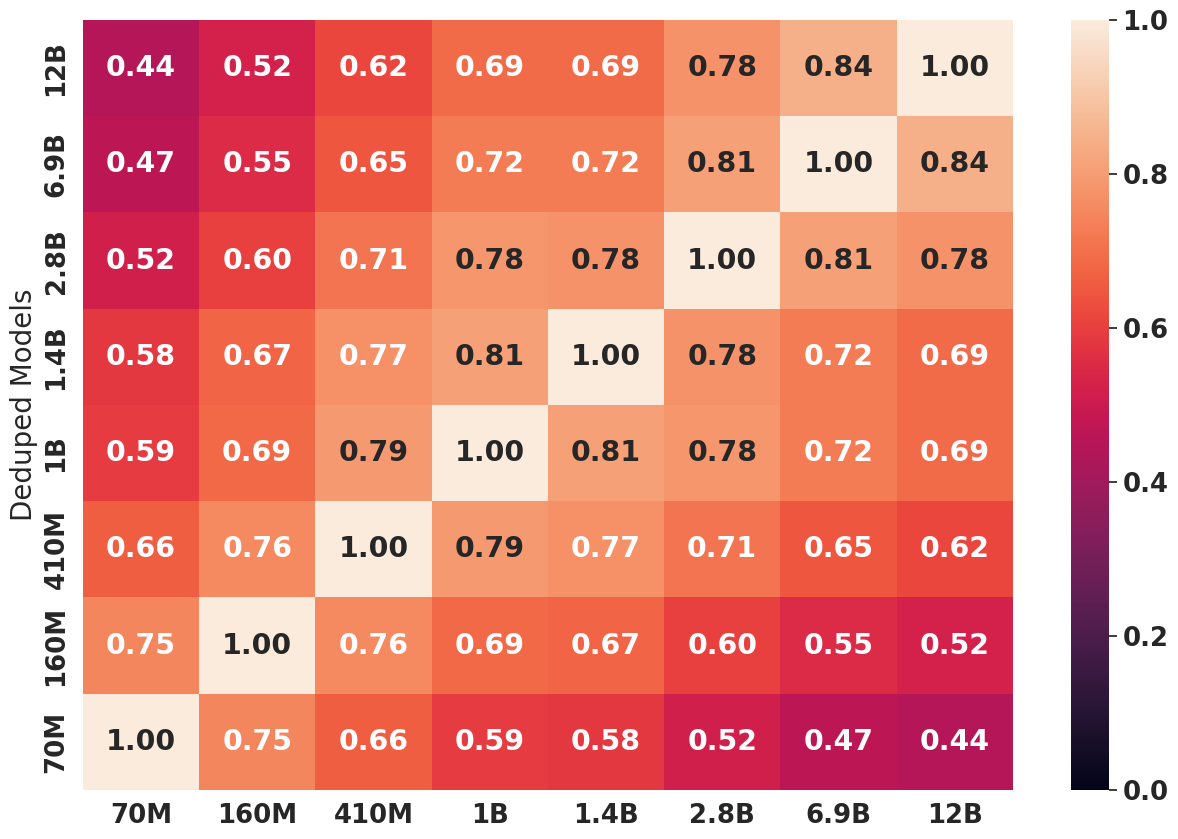

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import img2pdf
import numpy as np

def correlation_heatmap_of_models(percentile=0, checkpoint=143000):
    '''Plots Pearson'R correlation between models
    
    `percentile`: Most memorized data percentile
    '''
    # Theming
    plt.clf()
    plt.rcParams["figure.figsize"] = (32,32)
    sns.set_theme(font_scale=1.7)
    
    
    # We will use stats.pearsonr for correlation calculations
    df = {}
    for model in models:
        df[model] = memorization_results[f'{model}-{checkpoint}']['accuracy']
    
    # Extract top percentile evals if specified
    for model in models:
        if percentile > 0 and percentile != 1:
            top_percentile_acc = np.nanpercentile(df[f'{model}'],percentile)
            df[f'{model}'] = df[f'{model}'] >= top_percentile_acc
            df[f'{model}'] = df[f'{model}'].astype('float32').to_numpy()
        elif percentile == 1:
            df[f'{model}'] = df[f'{model}'] == 1
            df[f'{model}'] = df[f'{model}'].astype('float32')
    
    model_names = [m.split('-')[0] for m in models]
    correlation = pd.DataFrame(index = model_names)
    for model_1 in models:
        corrs = []
        for model_2 in tqdm(models, desc=model_1):
            acc_1 = df[model_1]
            acc_2 = df[model_2]
            corr = stats.pearsonr(acc_1, acc_2).statistic
            corrs.append(corr)
        correlation[model_names[models.index(model_1)]] = corrs
    
    # Heatmap we add annotations to also indicate value of pearson's R
    ax = sns.heatmap(correlation, annot=True, fmt='.2f', vmin=0, vmax=1, yticklabels = model_names, xticklabels = model_names)
    ax.invert_yaxis()
    checkpoint = checkpoint_names[checkpoints.index(checkpoint)]
    title = f"{checkpoint} Deduped Checkpoint Correlation Heatmap"
    if percentile == 1:
        title += f" on Memorized Indicies"
    elif percentile > 0:
        title += f" on top {percentile} Indicies"
#     plt.title(title, fontsize=25)
    plt.ylabel("Deduped Models", fontsize=20)
    plt.savefig('./plots/tmp.png')
    if percentile == 0:
        with open(f"./plots/model_correlation_deduped_{checkpoint}.pdf","wb") as f:
            f.write(img2pdf.convert('./plots/tmp.png'))
    elif percentile == 1:
        with open(f"./plots/model_correlation_deduped_{checkpoint}_acc1.pdf","wb") as f:
            f.write(img2pdf.convert('./plots/tmp.png'))
    else:
        with open(f"./plots/model_correlation_deduped_{checkpoint}_{percentile}_percentile.pdf","wb") as f:
            f.write(img2pdf.convert('./plots/tmp.png'))
update_params()
for checkpoint in checkpoints:
    correlation_heatmap_of_models(0, checkpoint)
    correlation_heatmap_of_models(90, checkpoint)
    correlation_heatmap_of_models(99, checkpoint)
    correlation_heatmap_of_models(1, checkpoint)

# Checkpoint correlation plots

70M-deduped-23000:   0%|          | 0/7 [00:00<?, ?it/s]

70M-deduped-43000:   0%|          | 0/7 [00:00<?, ?it/s]

70M-deduped-63000:   0%|          | 0/7 [00:00<?, ?it/s]

70M-deduped-83000:   0%|          | 0/7 [00:00<?, ?it/s]

70M-deduped-103000:   0%|          | 0/7 [00:00<?, ?it/s]

70M-deduped-123000:   0%|          | 0/7 [00:00<?, ?it/s]

70M-deduped-143000:   0%|          | 0/7 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


160M-deduped-23000:   0%|          | 0/7 [00:00<?, ?it/s]

160M-deduped-43000:   0%|          | 0/7 [00:00<?, ?it/s]

160M-deduped-63000:   0%|          | 0/7 [00:00<?, ?it/s]

160M-deduped-83000:   0%|          | 0/7 [00:00<?, ?it/s]

160M-deduped-103000:   0%|          | 0/7 [00:00<?, ?it/s]

160M-deduped-123000:   0%|          | 0/7 [00:00<?, ?it/s]

160M-deduped-143000:   0%|          | 0/7 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


410M-deduped-23000:   0%|          | 0/7 [00:00<?, ?it/s]

410M-deduped-43000:   0%|          | 0/7 [00:00<?, ?it/s]

410M-deduped-63000:   0%|          | 0/7 [00:00<?, ?it/s]

410M-deduped-83000:   0%|          | 0/7 [00:00<?, ?it/s]

410M-deduped-103000:   0%|          | 0/7 [00:00<?, ?it/s]

410M-deduped-123000:   0%|          | 0/7 [00:00<?, ?it/s]

410M-deduped-143000:   0%|          | 0/7 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


1B-deduped-23000:   0%|          | 0/7 [00:00<?, ?it/s]

1B-deduped-43000:   0%|          | 0/7 [00:00<?, ?it/s]

1B-deduped-63000:   0%|          | 0/7 [00:00<?, ?it/s]

1B-deduped-83000:   0%|          | 0/7 [00:00<?, ?it/s]

1B-deduped-103000:   0%|          | 0/7 [00:00<?, ?it/s]

1B-deduped-123000:   0%|          | 0/7 [00:00<?, ?it/s]

1B-deduped-143000:   0%|          | 0/7 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


1.4B-deduped-23000:   0%|          | 0/7 [00:00<?, ?it/s]

1.4B-deduped-43000:   0%|          | 0/7 [00:00<?, ?it/s]

1.4B-deduped-63000:   0%|          | 0/7 [00:00<?, ?it/s]

1.4B-deduped-83000:   0%|          | 0/7 [00:00<?, ?it/s]

1.4B-deduped-103000:   0%|          | 0/7 [00:00<?, ?it/s]

1.4B-deduped-123000:   0%|          | 0/7 [00:00<?, ?it/s]

1.4B-deduped-143000:   0%|          | 0/7 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


2.8B-deduped-23000:   0%|          | 0/7 [00:00<?, ?it/s]

2.8B-deduped-43000:   0%|          | 0/7 [00:00<?, ?it/s]

2.8B-deduped-63000:   0%|          | 0/7 [00:00<?, ?it/s]

2.8B-deduped-83000:   0%|          | 0/7 [00:00<?, ?it/s]

2.8B-deduped-103000:   0%|          | 0/7 [00:00<?, ?it/s]

2.8B-deduped-123000:   0%|          | 0/7 [00:00<?, ?it/s]

2.8B-deduped-143000:   0%|          | 0/7 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


6.9B-deduped-23000:   0%|          | 0/7 [00:00<?, ?it/s]

6.9B-deduped-43000:   0%|          | 0/7 [00:00<?, ?it/s]

6.9B-deduped-63000:   0%|          | 0/7 [00:00<?, ?it/s]

6.9B-deduped-83000:   0%|          | 0/7 [00:00<?, ?it/s]

6.9B-deduped-103000:   0%|          | 0/7 [00:00<?, ?it/s]

6.9B-deduped-123000:   0%|          | 0/7 [00:00<?, ?it/s]

6.9B-deduped-143000:   0%|          | 0/7 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


12B-deduped-23000:   0%|          | 0/7 [00:00<?, ?it/s]

12B-deduped-43000:   0%|          | 0/7 [00:00<?, ?it/s]

12B-deduped-63000:   0%|          | 0/7 [00:00<?, ?it/s]

12B-deduped-83000:   0%|          | 0/7 [00:00<?, ?it/s]

12B-deduped-103000:   0%|          | 0/7 [00:00<?, ?it/s]

12B-deduped-123000:   0%|          | 0/7 [00:00<?, ?it/s]

12B-deduped-143000:   0%|          | 0/7 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


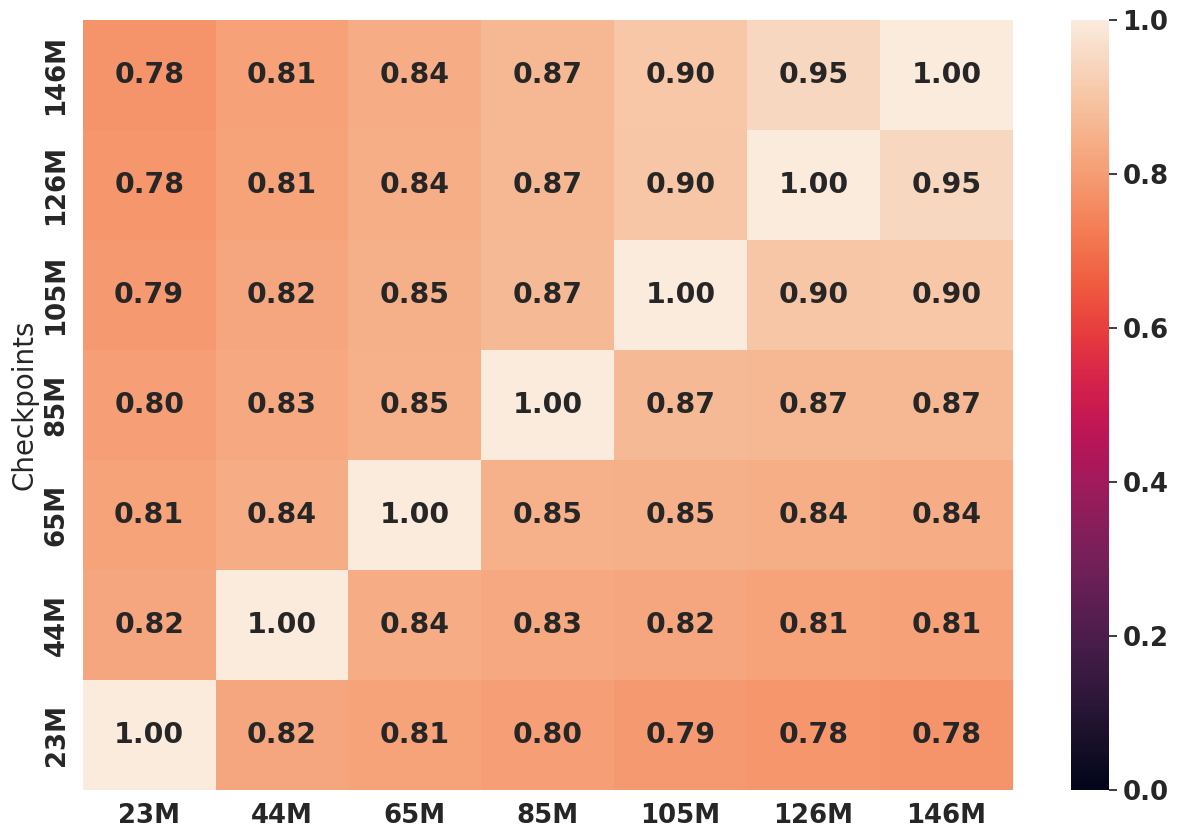

In [12]:
import scipy.stats as stats
def plot_correlation_heatmap_of_checkpoint(model):
    '''Plots Pearson'R correlation between checkpoints of a model
    
    `model`: Model to plot correlation of
    '''
    # Theming
    plt.clf()
    plt.rcParams["figure.figsize"] = (32,32)
    sns.set_theme(font_scale=1.7)
    
    
    # We will use stats.pearsonr for correlation calculations
    # We only consider Sequence indicies that are evaluated by all checkpoints
    max_sequence_index = 1024*23000
    df = {}
    for checkpoint in checkpoints:
        df[checkpoint] = memorization_results[f'{model}-{checkpoint}']
        df[checkpoint] = df[checkpoint][df[checkpoint]['index'] < max_sequence_index]
        df[checkpoint] = df[checkpoint]['accuracy'].to_numpy()
        
   
    # Get correlation
    correlation = pd.DataFrame(index = checkpoint_names)
    for checkpoint_1 in checkpoints:
        corrs = []
        for checkpoint_2 in tqdm(checkpoints, desc=f'{model}-{checkpoint_1}'):
            acc_1 = df[checkpoint_1]
            acc_2 = df[checkpoint_2]
            corr = stats.pearsonr(acc_1, acc_2).statistic
            corrs.append(corr)
        correlation[checkpoint_names[checkpoints.index(checkpoint_1)]] = corrs
    
    # Heatmap we add annotations to also indicate value of pearson's R
    ax = sns.heatmap(correlation, annot=True, fmt='.2f', vmin=0, vmax=1)
    ax.invert_yaxis()
    title = f"{model} Parameter Correlation Heatmap"
#     plt.title(title, fontsize=25)
    plt.ylabel("Checkpoints", fontsize=20)
    plt.savefig('./plots/tmp.png')
    
    # Save plots to pdf
    with open(f"./plots/checkpoint_correlation_{model}.pdf","wb") as f:
        f.write(img2pdf.convert('./plots/tmp.png'))
update_params()
for model in models:
    plot_correlation_heatmap_of_checkpoint(model)

# KS Test & Q-Q plot: Uniformity Experiments

19m-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_565016/742275120.py:98: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm) # label = "No. Overlapping Quantiles"
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


125m-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_565016/742275120.py:98: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm) # label = "No. Overlapping Quantiles"
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


350m-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_565016/742275120.py:98: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm) # label = "No. Overlapping Quantiles"
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


800m-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_565016/742275120.py:98: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm) # label = "No. Overlapping Quantiles"
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


1.3b-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_565016/742275120.py:98: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm) # label = "No. Overlapping Quantiles"
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


2.7b-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_565016/742275120.py:98: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm) # label = "No. Overlapping Quantiles"
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


6.7b-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_565016/742275120.py:98: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm) # label = "No. Overlapping Quantiles"
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


13b-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_565016/742275120.py:98: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm) # label = "No. Overlapping Quantiles"
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


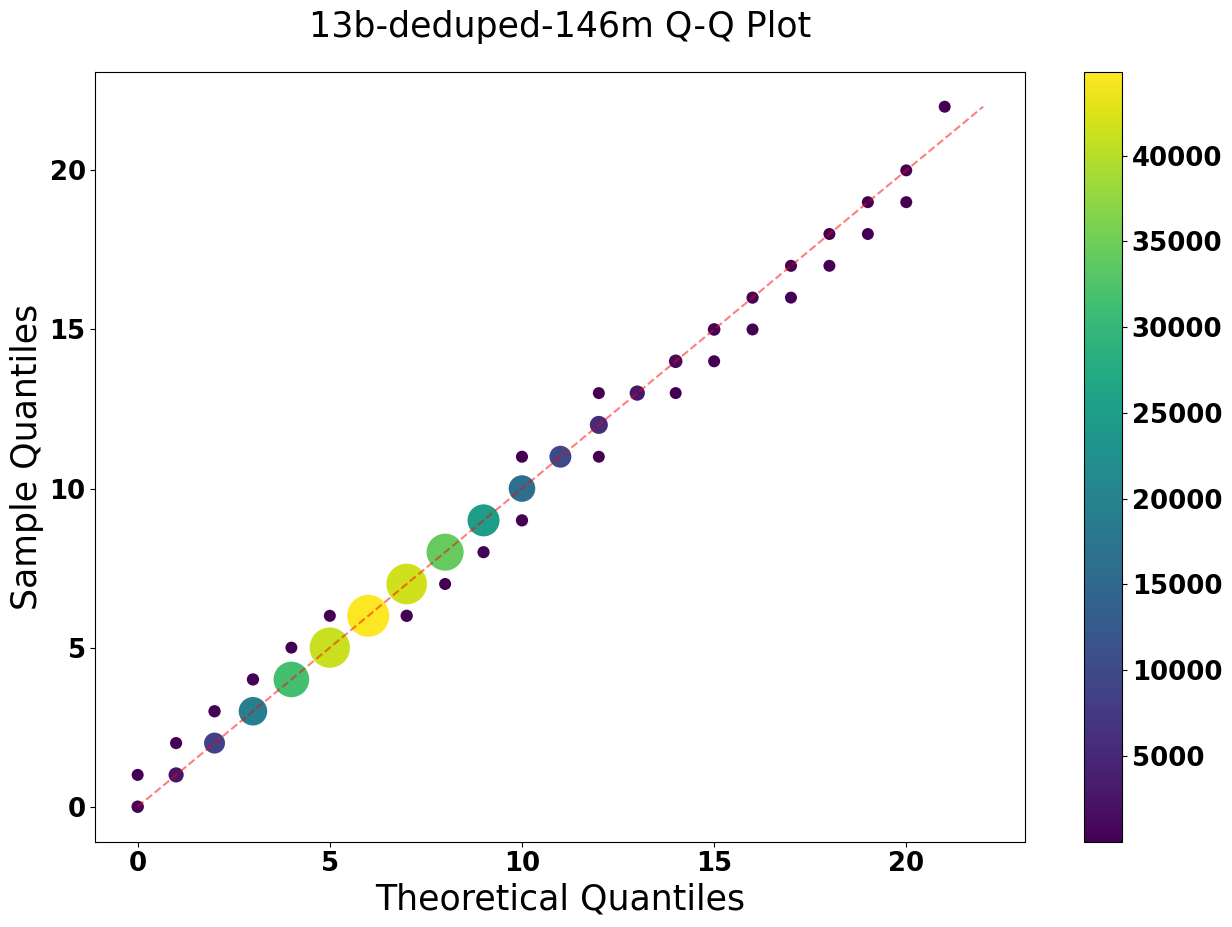

In [32]:
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as smapi
import matplotlib.pyplot as plt
import img2pdf

update_params()

def jitter(values,j):
    return values + np.random.normal(j,0.1,values.shape)

def qq_plot(model, checkpoint):
    '''Plots Q-Q plot of a given model's checkpoint
    
    If "fully memorized event" is defined as occurrence of a fully memorized sequence index at a given time instance,
    Where time instance for a given sequence is the index of that particular sequence within training data,
    It is observed that frequency of fully memorized events within a time-period is uniform.
    
    This statement is validated by the plotted Q-Q plots where theoretical distribution is Poisson distribution fit on 
    observed frequencies of events.
    '''
    # Clearing previous plots
    plt.clf()
    
    # Load data
    evals = memorization_results[f'{model}-{checkpoint}']
    
    # Extract fully memorized events
    evals['acc1'] = (evals['accuracy'] == 1).astype('int32')
    
    # Set batch size, also works as time unit for our temporal evaluation
    batch_size = 512
    
    # Get event frequencies, where each event is getting memorization_acc = 1
    freqs = []
    for i in range(0, checkpoint*1024, batch_size):
        num_acc_1 = evals['acc1'].iloc[i:i+batch_size].sum()
        freqs.append(num_acc_1)
    
    average_rate = np.mean(freqs)
    total_num_events = len(freqs)
        
    plotter = smapi.ProbPlot(
        np.array(freqs), 
        dist = stats.poisson(average_rate,), 
    )
    
    checkpoint = checkpoint_names[checkpoints.index(checkpoint)]
    data = pd.DataFrame()
    data['Sample Quantiles'] = plotter.sample_quantiles
    data['Theoretical Quantiles']= plotter.theoretical_quantiles
    
    dist = {}
    
    for idx, row in data.iterrows():
        x = row['Sample Quantiles']
        y = row['Theoretical Quantiles']
        if x in dist:
            if y in dist[x]:
                dist[x][y] += 1
            else:
                dist[x][y] = 1
        else:
            dist[x] = {}
            dist[x][y] = 1
    hueintensity = []
    for idx, row in data.iterrows():
        x = row['Sample Quantiles']
        y = row['Theoretical Quantiles']
        hueintensity.append(dist[x][y])
    
    norm = plt.Normalize(np.min(hueintensity), np.max(hueintensity))
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    
    # Reference line
    plt.plot(
        [0, max(freqs)], [0, max(freqs)], 
        color = 'red', 
        marker = None,
        linestyle='dashed',
        alpha = 0.5
    )
    
    
    ax = sns.scatterplot(
        data, 
        x = 'Theoretical Quantiles', 
        y = 'Sample Quantiles', 
        palette = 'viridis', 
        hue = hueintensity, 
        size = hueintensity,
        sizes = (100, 1000),
        legend = False
    )
    
    ax.figure.colorbar(sm) # label = "No. Overlapping Quantiles"
    plt.title(f"{model}-{checkpoint} Q-Q Plot")
    plt.savefig("./plots/tmp.png")
    with open(f"./plots/qq_plot_{model}-{checkpoint}.pdf","wb") as f:
        f.write(img2pdf.convert('./plots/tmp.png'))
    

for model in models:
    for checkpoint in tqdm(checkpoints[-1:], desc=model):
        qq_plot(model, checkpoint)
        

In [25]:
len(memorization_results['13b-143000'][memorization_results['13b-143000']['accuracy'] == 0.03125])

34340259

In [26]:
34340259/146432000

0.2345133509069056